# LDA version 2 based on previous stackoverflow studies on STORIES

## setup

In [1]:
import umap
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# For LDA coherence
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

c:\Users\prach\miniconda3\envs\naist-2025\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
HN_STORIES_GH_AI_CSV = '/content/drive/MyDrive/datasets/muict-naist-senior/rq1/rq1_freq_analysis/rq1_stories_all.csv'
EXPORT_MODEL_PATH = '/content/drive/MyDrive/datasets/muict-naist-senior/rq1/rq1_lda/lda_model_all.pkl'


In [ ]:
# Download required NLTK data
print("Downloading NLTK data...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

# Load the data
print("Loading data...")
df = pd.read_csv(HN_STORIES_GH_AI_CSV)

Loading data...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## preprocessing

In [78]:
tqdm.pandas() # initialize tqdm for pandas

# Combine title and comment text
df['combined_text'] = df['title']

# Text preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    stemmer = nltk.stem.PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into text
    return ' '.join(tokens)

# Preprocess all combined text
print("Preprocessing combined text...")
df['processed_text'] = df['combined_text'].progress_apply(preprocess_text) # for tqdm

# Remove empty comments after preprocessing
df = df[df['processed_text'].str.len() > 0].reset_index(drop=True)

Preprocessing combined text...


100%|██████████| 4645/4645 [00:02<00:00, 1646.16it/s]


## Wordclouds after preprocessing

This was done after preprocessing (stemming, lemmatization, etc.) so that similar words will be categorized as the same word e.g. "llm" and "llms" would be considered as the same word

Generating word cloud...


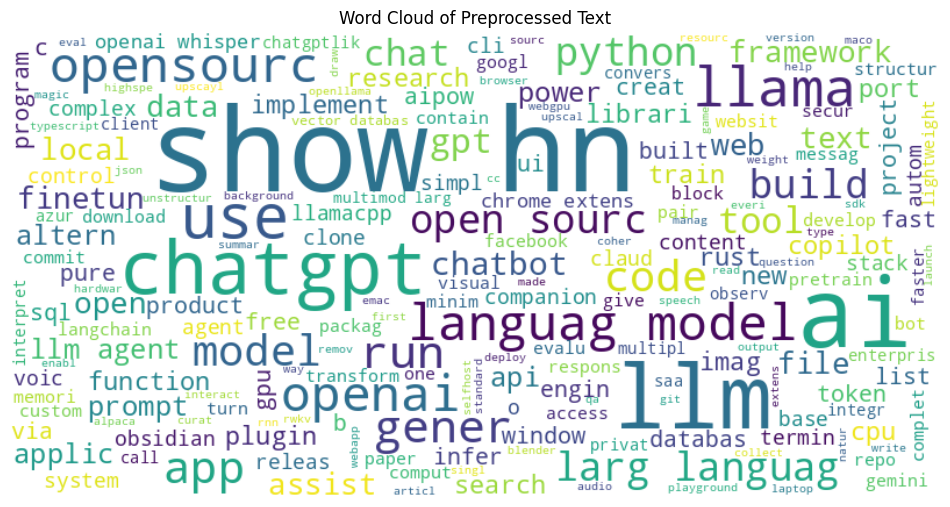

In [ ]:
from wordcloud import WordCloud

# Create a single string from the preprocessed text
all_text = ' '.join(df['processed_text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_font_size=100).generate(all_text)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Preprocessed Text")
plt.show()

## transform to tf-idf matrix and select only the top 100 terms (setup ends here)

In [ ]:
NUM_TOP_TERMS = 100  # Number of top terms to consider

In [ ]:
# Create TF-IDF matrix
print("Creating TF-IDF matrix...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

# Dimensionality reduction using UMAP for faster processing
print("Reducing dimensionality with UMAP...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
reduced_tfidf = reducer.fit_transform(tfidf_matrix)

# Select top N terms based on TF-IDF scores
top_term_indices = np.argsort(tfidf_matrix.sum(axis=0).A1)[-NUM_TOP_TERMS:]
top_terms = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_term_indices]

# Subset the TF-IDF matrix for selected terms
subset_tfidf = tfidf_matrix[:, top_term_indices]

Creating TF-IDF matrix...
Reducing dimensionality with UMAP...


## Evaluate best topics numbers - using coherence, perplexity, silhouette scores

hyperparameter: number of topic (k), document-topic density (alpha), word-topic density (beta)

Setup functions used to evaluate the optimal number of topics. According to [this](https://www.baeldung.com/cs/topic-modeling-coherence-score), many ways to calculate coherence score. Previously used cv (before 6/1/2025), which was not recommended. Currently using umass.

visualizing coherence scores for each number of topic
- coherence: measures interpretability of the topics i.e. how well top words make sense together, and whether they co-occur frequently in the dataset
  - higher means topics are more meaningful and interpretable
  - `u_mass` based on word co-occurence
  - `c_v` previously measures the agreement using sliding window and cosine similarity
- perplexity: measures how well topic model predicts unseen data
  - lower indicates better generalization
  - can be misleading: low perplexity may still result in incoherent or nonsensical topics
- silhouette: how well separated  and cohesive the clusters are
  - higher means data points in the topic are more similar to each other, and less similar to other topics
  - not often used in lda because one story can belong to multiple topics based on probability, whereas silhouette assumes one story belongs to exactly one topic

## Evaluate the best number of topics

per-topic coherence, topic diversity, umass and npmi coherence, perplexity

In [47]:
# Prepare tokenized corpus for CoherenceModel
tokenized_corpus = [text.split() for text in df['processed_text']]  # Tokenize processed text

# Create Gensim dictionary from tokenized corpus
dictionary = Dictionary(tokenized_corpus)
corpus = [dictionary.doc2bow(text) for text in tokenized_corpus]

In [ ]:
from gensim.models import LdaModel, CoherenceModel
from gensim.matutils import Sparse2Corpus
from tqdm import tqdm
import numpy as np
import pandas as pd

def calculate_topic_diversity(model, topn=10):
    """Calculate topic diversity based on unique words in top N words of all topics"""
    topics = model.show_topics(num_topics=-1, num_words=topn, formatted=False)
    unique_words = set()
    total_words = 0

    for topic_id, topic_words in topics:
        words = [word for word, _ in topic_words]
        unique_words.update(words)
        total_words += len(words)

    return len(unique_words) / total_words

def calculate_per_topic_coherence(model, texts, dictionary):
    """Calculate coherence scores for individual topics"""
    cm = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    per_topic_coherence = cm.get_coherence_per_topic()

    return per_topic_coherence

def evaluate_topics(doc_term_matrix, max_topics, tokenized_corpus, dictionary, random_state=42):
    coherence_scores_umass = []
    coherence_scores_npmi = []
    perplexity_scores = []
    silhouette_scores = []
    topic_diversity_scores = []
    per_topic_coherence_data = []

    # Convert sparse matrix to Gensim corpus format
    corpus = Sparse2Corpus(doc_term_matrix, documents_columns=False)

    for n_topics in tqdm(range(2, max_topics + 1)):
        lda = LdaModel(corpus=corpus,
                      id2word=dictionary,
                      num_topics=n_topics,
                      random_state=random_state,
                      passes=10)

        # Calculate UMass coherence
        coherence_umass = CoherenceModel(model=lda, texts=tokenized_corpus,
                                       dictionary=dictionary, coherence='u_mass')
        coherence_scores_umass.append(coherence_umass.get_coherence())

        # Calculate NPMI coherence (c_v)
        coherence_npmi = CoherenceModel(model=lda, texts=tokenized_corpus,
                                      dictionary=dictionary, coherence='c_v')
        coherence_scores_npmi.append(coherence_npmi.get_coherence())

        # Calculate per-topic coherence
        topic_coherence_scores = calculate_per_topic_coherence(lda, tokenized_corpus, dictionary)
        per_topic_coherence_data.append({
            'n_topics': n_topics,
            'topic_scores': topic_coherence_scores,
            'min_coherence': np.min(topic_coherence_scores),
            'max_coherence': np.max(topic_coherence_scores),
            'mean_coherence': np.mean(topic_coherence_scores)
        })

        # Calculate topic diversity
        topic_diversity = calculate_topic_diversity(lda)
        topic_diversity_scores.append(topic_diversity)

        # Calculate perplexity
        perplexity_scores.append(lda.log_perplexity(corpus))

    return {
        'umass_coherence': coherence_scores_umass,
        'npmi_coherence': coherence_scores_npmi,
        'perplexity': perplexity_scores,
        'topic_diversity': topic_diversity_scores,
        'per_topic_coherence': per_topic_coherence_data
    }

In [ ]:
MAX_TOPICS_EVAL = 50
results = evaluate_topics(tfidf_matrix, MAX_TOPICS_EVAL, tokenized_corpus, dictionary)

100%|██████████| 49/49 [02:31<00:00,  3.09s/it]


In [50]:
def plot_evaluation_metrics(results, max_topics):
    fig, axes = plt.subplots(5, figsize=(15, 20))
    topic_range = range(2, max_topics + 1)

    # Plot UMass Coherence
    axes[0].plot(topic_range, results['umass_coherence'], marker='o', color='blue')
    axes[0].set_title('UMass Coherence Score\n(Lower = better)')
    axes[0].set_xticks(range(2, max_topics + 1, 2))
    axes[0].set_xlabel('Number of Topics')
    axes[0].set_ylabel('Coherence Score')
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Plot NPMI Coherence
    axes[1].plot(topic_range, results['npmi_coherence'], marker='o', color='green')
    axes[1].set_title('NPMI Coherence Score\n(Higher = better)')
    axes[1].set_xticks(range(2, max_topics + 1, 2))
    axes[1].set_xlabel('Number of Topics')
    axes[1].set_ylabel('Coherence Score')
    axes[1].grid(True, linestyle='--', alpha=0.6)

    # Plot Topic Diversity
    axes[2].plot(topic_range, results['topic_diversity'], marker='s', color='purple')
    axes[2].set_title('Topic Diversity\n(Higher = more diverse topics)')
    axes[2].set_xticks(range(2, max_topics + 1, 2))
    axes[2].set_xlabel('Number of Topics')
    axes[2].set_ylabel('Diversity Score')
    axes[2].grid(True, linestyle='--', alpha=0.6)

    # Plot Per-topic Coherence Statistics
    topic_coherence_df = pd.DataFrame(results['per_topic_coherence'])
    axes[3].plot(topic_coherence_df['n_topics'], topic_coherence_df['mean_coherence'],
                   label='Mean', color='blue')
    axes[3].fill_between(topic_coherence_df['n_topics'],
                           topic_coherence_df['min_coherence'],
                           topic_coherence_df['max_coherence'],
                           alpha=0.2, color='blue', label='Range')
    axes[3].set_title('Per-topic Coherence Statistics')
    axes[3].set_xticks(range(2, max_topics + 1, 2))
    axes[3].set_xlabel('Number of Topics')
    axes[3].set_ylabel('Coherence Score')
    axes[3].legend()
    axes[3].grid(True, linestyle='--', alpha=0.6)

    # Plot Perplexity
    axes[4].plot(topic_range, results['perplexity'], marker='x', color='red')
    axes[4].set_title('Log Perplexity\n(Lower = better)')
    axes[4].set_xticks(range(2, max_topics + 1, 2))
    axes[4].set_xlabel('Number of Topics')
    axes[4].set_ylabel('Log Perplexity')
    axes[4].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

visualizing coherence scores for each number of topic
- coherence: measures interpretability of the topics i.e. how well top words make sense together, and whether they co-occur frequently in the dataset
  - higher means topics are more meaningful and interpretable
  - `u_mass` based on word co-occurence
  - `c_v` previously measures the agreement using sliding window and cosine similarity
- perplexity: measures how well topic model predicts unseen data
  - lower indicates better generalization
  - can be misleading: low perplexity may still result in incoherent or nonsensical topics

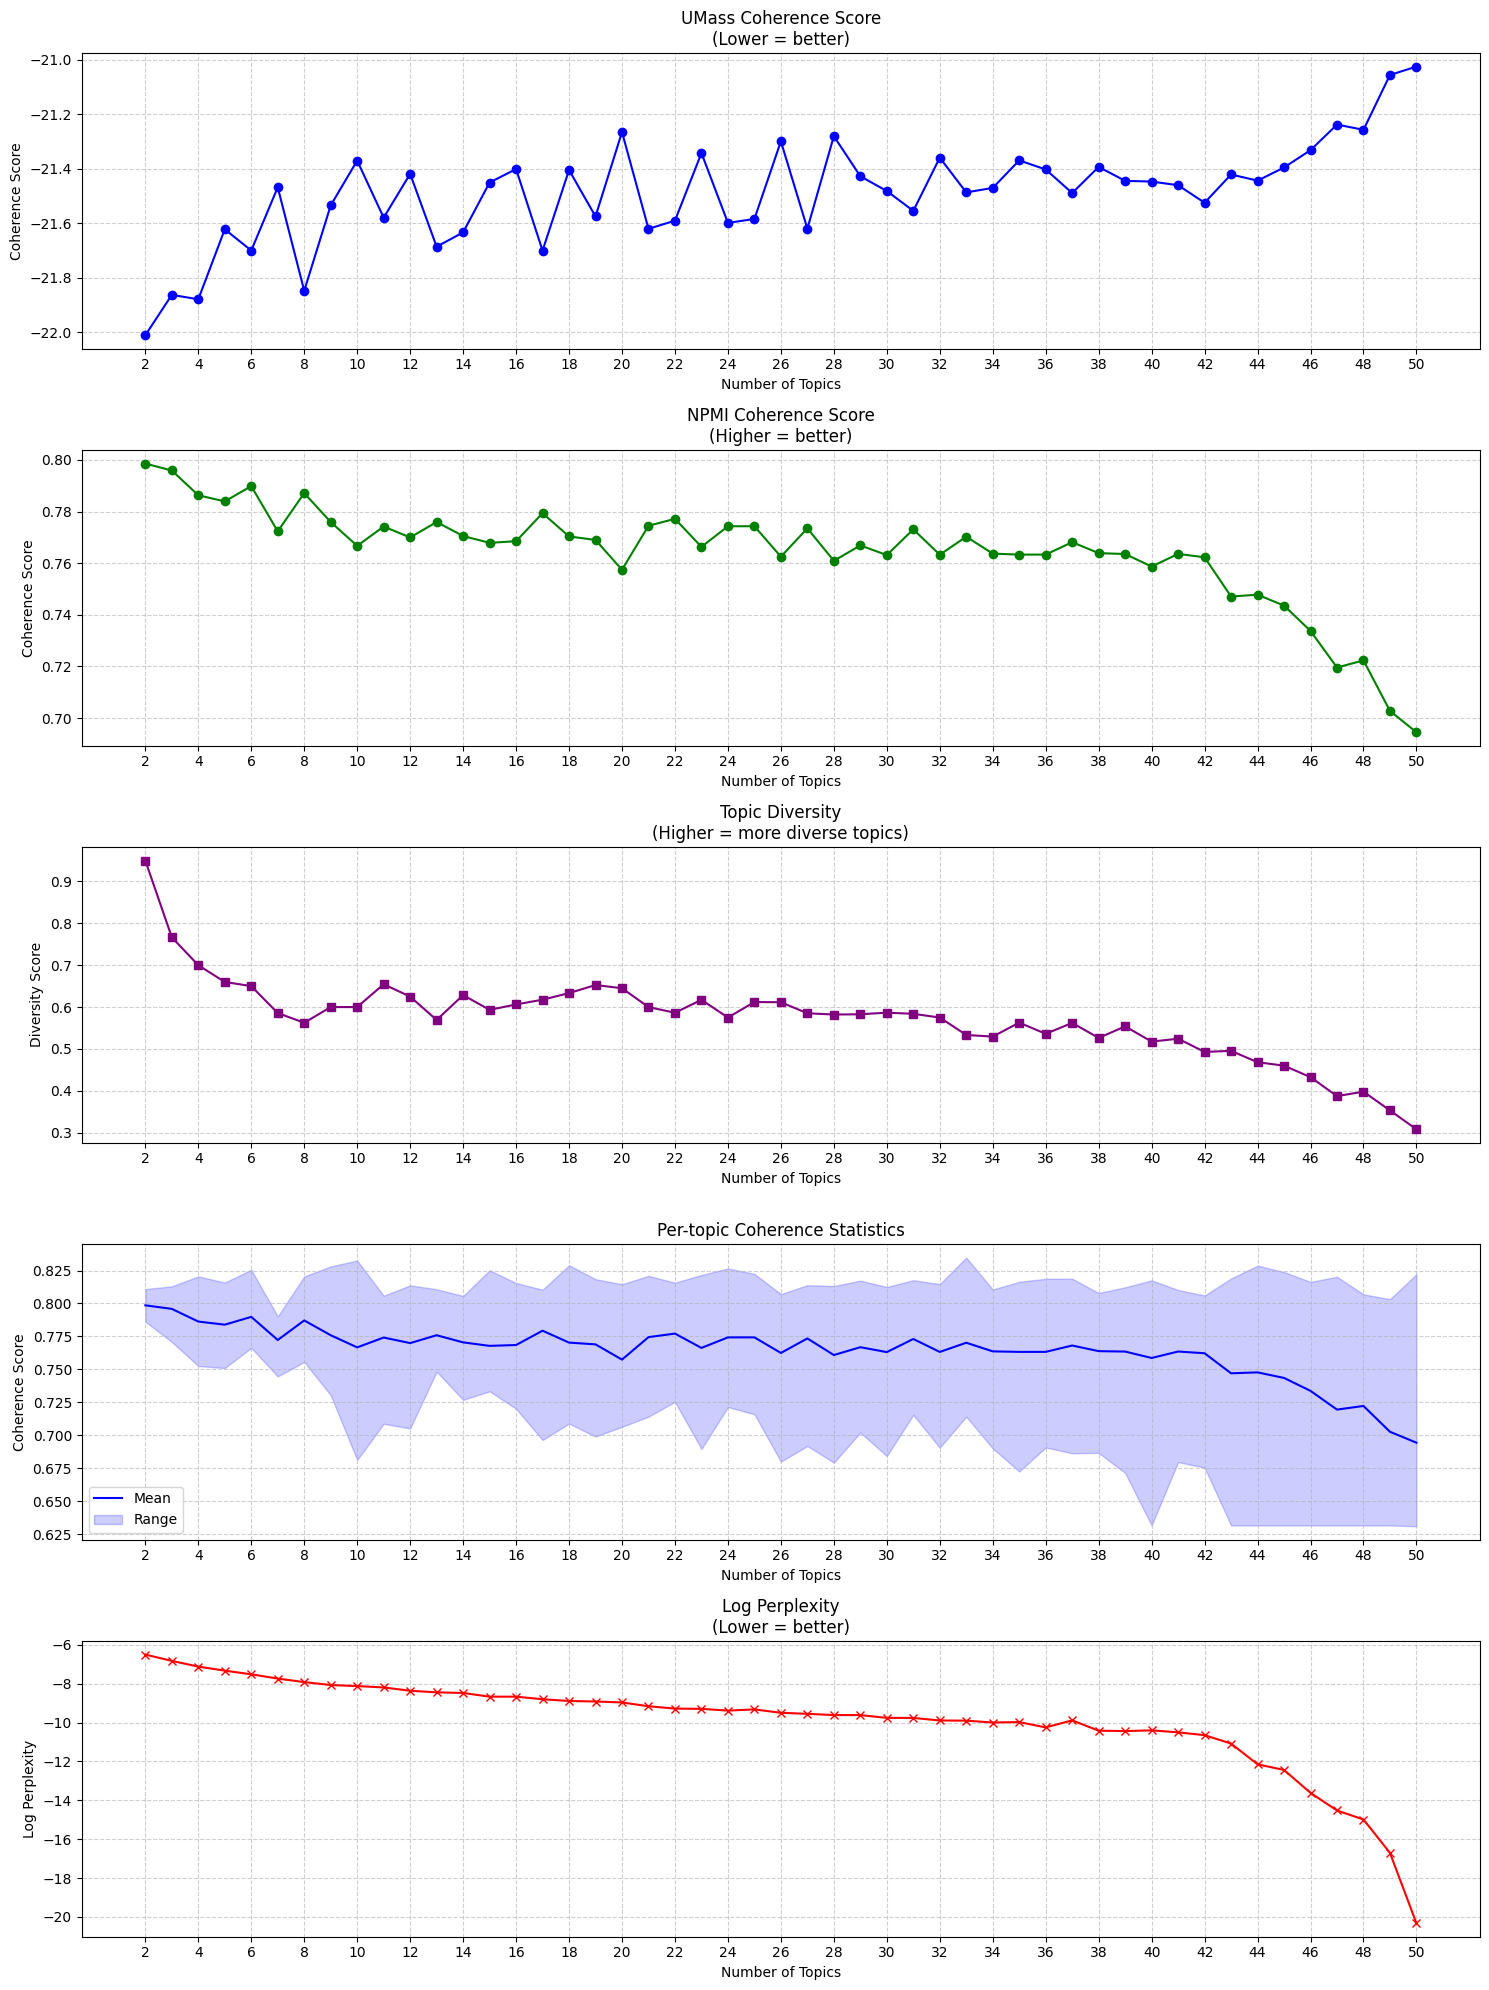

In [ ]:
plot_evaluation_metrics(results, MAX_TOPICS_EVAL)

## Train LDA model

In [ ]:
N_TOPICS = 4

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Train final LDA model with optimal number of topics
print(f"Training final LDA model with {N_TOPICS} topics...")

lda_model = LatentDirichletAllocation(n_components=N_TOPICS,
                                     random_state=42,
                                     n_jobs=-1)
lda_output = lda_model.fit_transform(tfidf_matrix)

Training final LDA model with 4 topics...


In [82]:
# Print top terms for each topic
feature_names = tfidf_vectorizer.get_feature_names_out()
n_top_words = 10

print("\nTop terms per topic:")
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_idx = topic.argsort()[:-n_top_words-1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")


Top terms per topic:
Topic 1: ai, model, llama, languag, googl, chatgpt, llm, train, run, larg
Topic 2: hn, ai, show, ask, chatgpt, llm, gener, use, openai, build
Topic 3: openai, ai, chatgpt, altman, microsoft, sam, new, board, hn, show
Topic 4: ai, chatgpt, use, gener, research, say, openai, new, photo, startup


## pyLDAvis to visualize topics

In [85]:
# Create interactive visualization
print("\nGenerating interactive visualization...")
pyLDAvis.enable_notebook()

# Convert the scikit-learn LDA model to a gensim LDA model
import gensim
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel

corpus = Sparse2Corpus(tfidf_matrix, documents_columns=False)  # Convert tfidf_matrix to a Gensim corpus
id2word = {i: word for i, word in enumerate(tfidf_vectorizer.get_feature_names_out())}  # Create a dictionary mapping word IDs to words
gensim_lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=lda_model.n_components,
    random_state=lda_model.random_state,
    passes=10
)

# Then, use the gensim model for visualization
vis = pyLDAvis.gensim_models.prepare(gensim_lda_model, corpus, dictionary=dictionary)
pyLDAvis.display(vis)


Generating interactive visualization...


IndexError: index 1598 is out of bounds for axis 1 with size 806

## Add topic labels to the stories dataset

In [ ]:
# Add topic labels to original dataframe
df['dominant_topic'] = lda_output.argmax(axis=1)

HN_TOPIC_CSV_PATH = '/content/drive/MyDrive/datasets/muict-naist-senior/rq1/rq1_lda/rq1_stories_topics_all.csv'
df.to_csv(HN_TOPIC_CSV_PATH, index=False)

## Visualize topic distribution over time

In [ ]:
import pandas as pd

df_topics = pd.read_csv(HN_TOPIC_CSV_PATH)

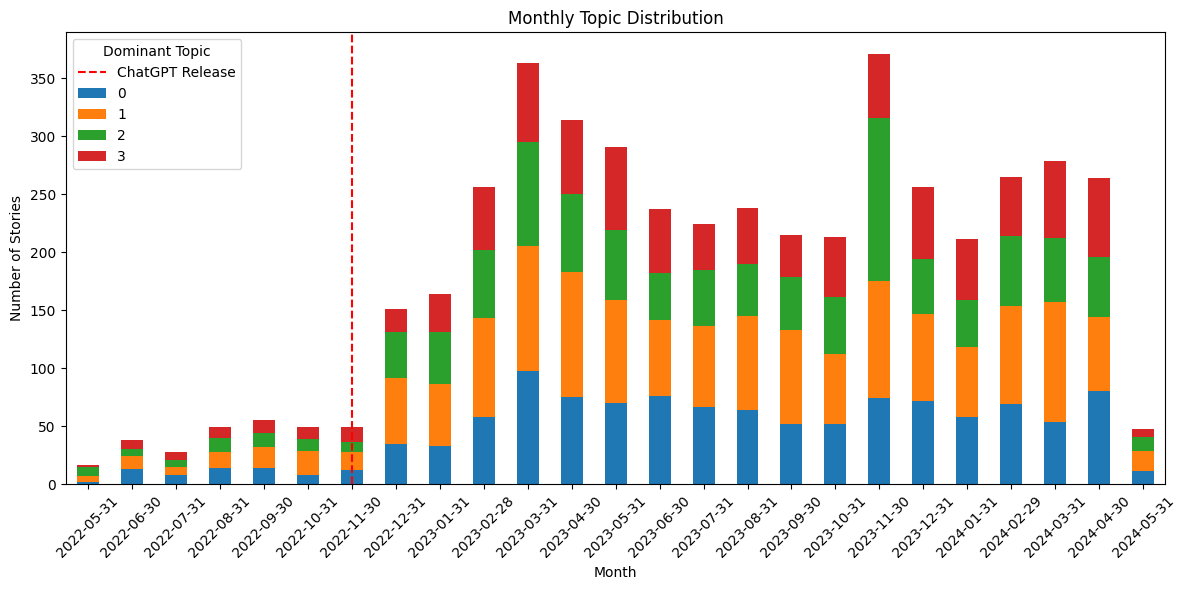

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'date' column to datetime objects
df_topics['date'] = pd.to_datetime(df_topics['date'], unit='s')

# Group by month and dominant topic, count occurrences
monthly_topic_distribution = df_topics.groupby([pd.Grouper(key='date', freq='M'), 'dominant_topic']).size().unstack(fill_value=0)

# Format the index to show only YYYY-MM-DD
monthly_topic_distribution.index = monthly_topic_distribution.index.strftime('%Y-%m-%d')

# Plot the topic distribution over time
ax = monthly_topic_distribution.plot(kind='bar', stacked=True, figsize=(12, 6))

# Add a dashed red line for ChatGPT release date
chatgpt_release_date = '2022-11-30'  # Changed to string format to match index
chatgpt_index = monthly_topic_distribution.index.get_loc(chatgpt_release_date)
ax.axvline(x=chatgpt_index, color='red', linestyle='--', label='ChatGPT Release')

# Customize plot
plt.title('Monthly Topic Distribution')
plt.xlabel('Month')
plt.ylabel('Number of Stories')
plt.xticks(rotation=45)
plt.legend(title='Dominant Topic', loc='upper left')
plt.tight_layout()

plt.show()

normalized version

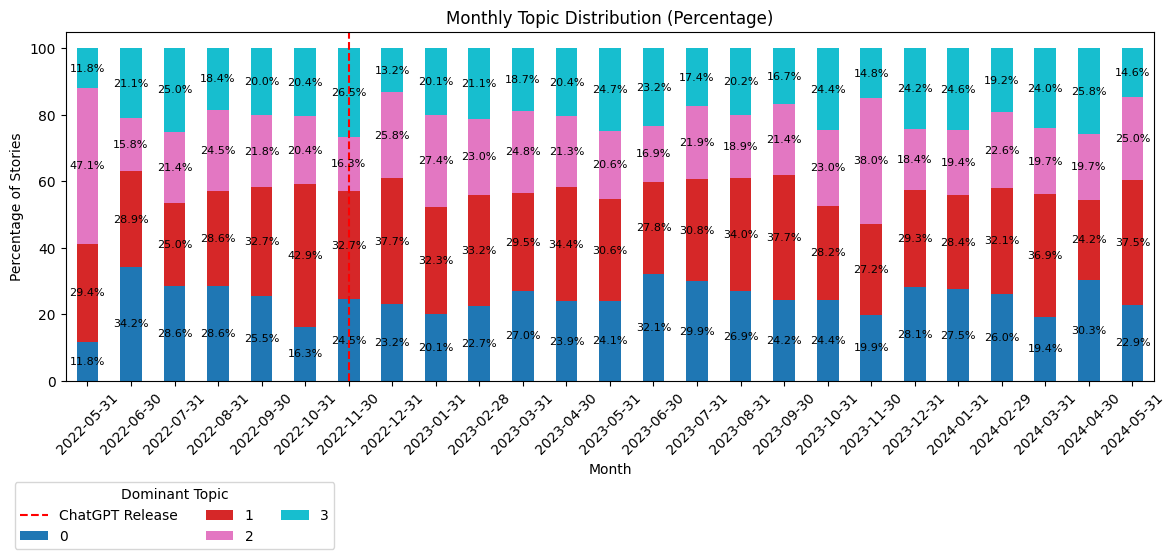

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'date' column to datetime objects
df_topics['date'] = pd.to_datetime(df_topics['date'], unit='s')

# Group by month and dominant topic, count occurrences
monthly_topic_distribution = df_topics.groupby([pd.Grouper(key='date', freq='M'), 'dominant_topic']).size().unstack(fill_value=0)

# Normalize the counts to percentages
monthly_topic_percentage = monthly_topic_distribution.div(monthly_topic_distribution.sum(axis=1), axis=0) * 100

# Plot the topic distribution as percentages
ax = monthly_topic_percentage.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab10')

# Format the index to show only YYYY-MM-DD
monthly_topic_percentage.index = monthly_topic_percentage.index.strftime('%Y-%m-%d')

# Annotate each portion with its percentage value
for container in ax.containers:
    for bar in container:
        if bar.get_height() > 0:  # Only annotate non-zero values
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X position
                bar.get_y() + bar.get_height() / 2,  # Y position
                f'{bar.get_height():.1f}%',  # Text to display
                ha='center', va='center', fontsize=8, color='black'
            )

# Add a dashed red line for ChatGPT release date
chatgpt_release_date = '2022-11-30'  # Changed to string format
chatgpt_index = monthly_topic_percentage.index.get_loc(chatgpt_release_date)
ax.axvline(x=chatgpt_index, color='red', linestyle='--', label='ChatGPT Release')
ax.set_xticklabels([x.split(' ')[0] for x in monthly_topic_percentage.index.astype(str)])

# Customize plot
plt.title('Monthly Topic Distribution (Percentage)')
plt.xlabel('Month')
plt.ylabel('Percentage of Stories')
plt.xticks(rotation=45)
plt.legend(title='Dominant Topic', bbox_to_anchor=(0.1, -0.27), loc='upper center', ncol=3)
plt.tight_layout()

plt.show()


## t-SNE eval v3a

## t-SNE evaluation

evaluate parameters

In [ ]:
# Update TSNE evaluation function
def evaluate_tsne_parameters(lda_output, perplexities=None, n_iter=1000):
    if perplexities is None:
        perplexities = [5, 10, 30, 50, 100]

    results = []

    original_distances = squareform(pdist(lda_output))

    for perp in perplexities:
        tsne = TSNE(n_components=2, perplexity=perp, n_iter=n_iter, random_state=42)
        tsne_output = tsne.fit_transform(lda_output)

        kl_divergence = tsne.kl_divergence_
        tsne_distances = squareform(pdist(tsne_output))
        distance_correlation = np.corrcoef(original_distances.ravel(), tsne_distances.ravel())[0, 1]

        # Using compute_trustworthiness function
        trustworthiness = compute_trustworthiness(lda_output, tsne_output, n_neighbors=5, random_state=42)

        results.append({
            'perplexity': perp,
            'kl_divergence': kl_divergence,
            'distance_correlation': distance_correlation,
            'trustworthiness': trustworthiness
        })

    return pd.DataFrame(results)

In [ ]:
results = evaluate_tsne_parameters(lda_output)
sns.pairplot(results)
plt.suptitle('t-SNE Evaluation Metrics')
plt.show()

# Evaluate the best parameters
best_result = results.loc[results['trustworthiness'].idxmax()]
print('\nBest Parameters:')
print(best_result)

NameError: name 'compute_trustworthiness' is not defined

## t-SNE version 2 (4 good clusters)

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def create_improved_tsne_viz(tfidf_matrix, lda_output, df, perplexity=30, n_iter=5000):
    """
    Creates an improved t-SNE visualization with better separation of topics.

    Args:
        tfidf_matrix: TF-IDF matrix of documents
        lda_output: Topic distribution matrix from LDA
        df: Original dataframe containing the data
        perplexity: t-SNE perplexity parameter (default=30)
        n_iter: Number of iterations for t-SNE (default=1000)
    """
    # Use LDA topic distributions instead of TF-IDF for t-SNE
    # This should give better separation as it uses the topic probabilities
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        n_iter=n_iter,
        random_state=42,
        learning_rate='auto',
        init='pca'  # Initialize with PCA for better global structure
    )

    tsne_output = tsne.fit_transform(lda_output)

    # Create the visualization
    plt.figure(figsize=(12, 8))

    # Create scatter plot with improved aesthetics
    scatter = plt.scatter(
        tsne_output[:, 0],
        tsne_output[:, 1],
        c=df['dominant_topic'],
        cmap='Set3',  # Using a qualitative colormap
        alpha=0.6,    # Add some transparency
        s=100        # Increase point size
    )

    # Add topic labels to the plot
    unique_topics = sorted(df['dominant_topic'].unique())
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor=scatter.cmap(scatter.norm(topic)),
                                 label=f'Topic {topic+1}',
                                 markersize=10)
                      for topic in unique_topics]

    plt.legend(handles=legend_elements, title='Topics',
              bbox_to_anchor=(1.05, 1), loc='upper left')

    # Improve plot aesthetics
    plt.title('t-SNE Visualization of Story Topics', fontsize=14, pad=20)
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.3)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    return tsne_output

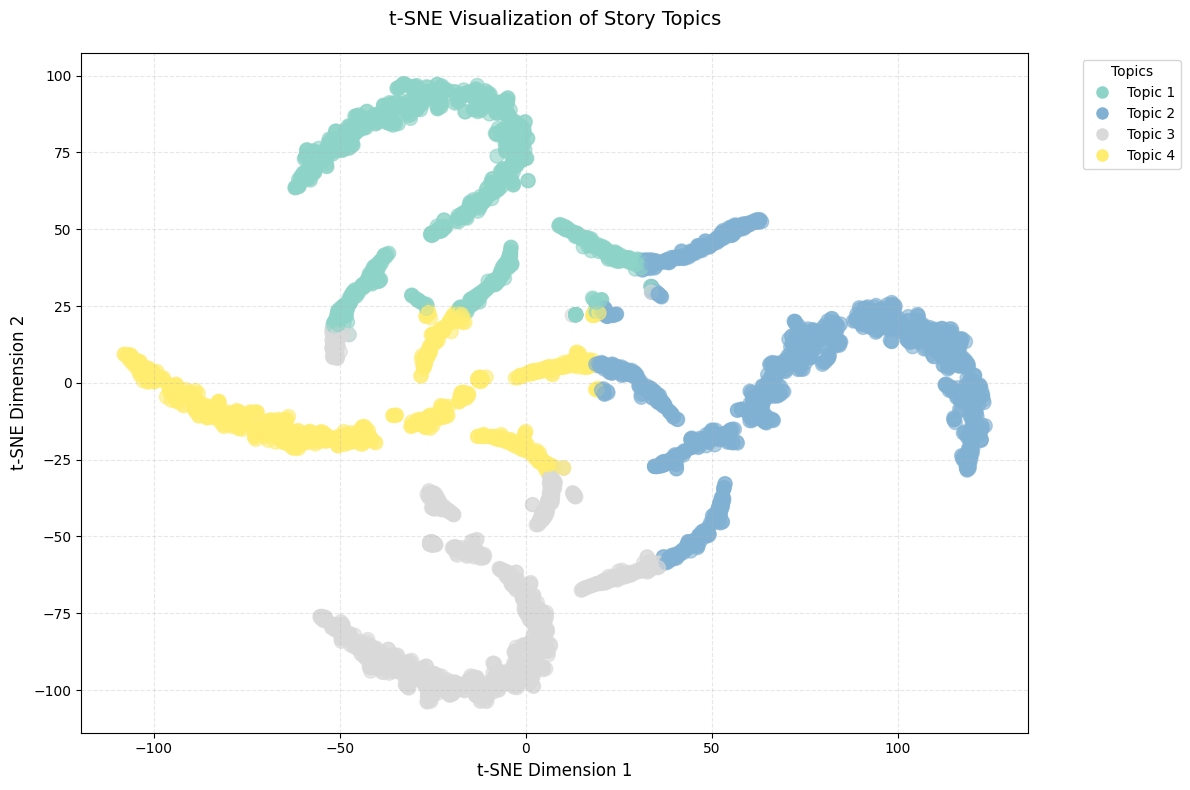

In [88]:
# Create the improved t-SNE visualization
tsne_output = create_improved_tsne_viz(tfidf_matrix, lda_output, df)

obtaining tsne output

In [ ]:
# from sklearn.manifold import TSNE
# import numpy as np

# # Perform t-SNE
# print("Performing t-SNE...")
# tsne = TSNE(n_components=2, random_state=42)
# tsne_output = tsne.fit_transform(np.asarray(tfidf_matrix.todense()))

analyze each cluster's probability

In [ ]:
# Function to analyze topic clusters
def analyze_topic_clusters(tsne_output, df, lda_model, feature_names):
    """
    Analyzes the separation of topics in t-SNE space

    Args:
        tsne_output: t-SNE coordinates
        df: Original dataframe
        lda_model: Trained LDA model
        feature_names: Feature names from TF-IDF vectorizer
    """
    # Calculate cluster centroids
    centroids = []
    for topic in range(lda_model.n_components):
        mask = df['dominant_topic'] == topic
        centroids.append(np.mean(tsne_output[mask], axis=0))

    # Calculate average distance between centroids
    centroid_distances = []
    for i in range(len(centroids)):
        for j in range(i+1, len(centroids)):
            dist = np.linalg.norm(np.array(centroids[i]) - np.array(centroids[j]))
            centroid_distances.append(dist)

    print("\nTopic Separation Analysis:")
    print(f"Average distance between topic centroids: {np.mean(centroid_distances):.2f}")

    # Print top terms for each topic with their weights
    print("\nTop terms per topic with weights:")
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words_idx = topic.argsort()[:-10-1:-1]
        top_words = [(feature_names[i], topic[i]) for i in top_words_idx]
        print(f"\nTopic {topic_idx + 1}:")
        for word, weight in top_words:
            print(f"  {word}: {weight:.4f}")


In [ ]:
analyze_topic_clusters(tsne_output, df, lda_model, tfidf_vectorizer.get_feature_names_out())


Topic Separation Analysis:
Average distance between topic centroids: 27.13

Top terms per topic with weights:

Topic 1:
  hn: 8.3173
  show: 8.1412
  python: 6.2925
  run: 6.2407
  llm: 6.1016
  ai: 5.6678
  local: 4.0625
  assist: 3.8403
  code: 3.8007
  llama: 3.6551

Topic 2:
  languag: 10.7772
  model: 9.9084
  show: 9.8946
  hn: 9.8447
  chatgpt: 7.5938
  app: 7.4730
  opensourc: 6.9735
  llm: 5.9987
  larg: 5.7337
  use: 4.9600

Topic 3:
  ai: 8.3883
  open: 7.9346
  llm: 7.0345
  sourc: 5.6852
  show: 4.5732
  hn: 4.5492
  agent: 4.1090
  llama: 3.6859
  chatgpt: 3.6643
  tool: 3.6088

Topic 4:
  gener: 8.0654
  openai: 7.3842
  ai: 5.7368
  show: 5.3100
  hn: 5.2833
  prompt: 4.5524
  llm: 3.5901
  chatgpt: 3.2230
  search: 2.6894
  engin: 2.6695


## Wordcloud for each topic

In [ ]:
def create_wordcloud_for_topics(lda_model, feature_names, n_top_words=20):
    """
    Generates word clouds for each topic in the LDA model.

    Args:
        lda_model: Trained LDA model.
        feature_names: List of feature names (words) from the TF-IDF vectorizer.
        n_top_words: Number of top words to include in each word cloud.
    """

    for topic_idx, topic in enumerate(lda_model.components_):
        top_words_idx = topic.argsort()[:-n_top_words-1:-1]
        top_words = [(feature_names[i], topic[i]) for i in top_words_idx]

        # Create a dictionary of word frequencies for the word cloud
        word_freq = dict(top_words)

        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for Topic {topic_idx + 1}")
        plt.show()

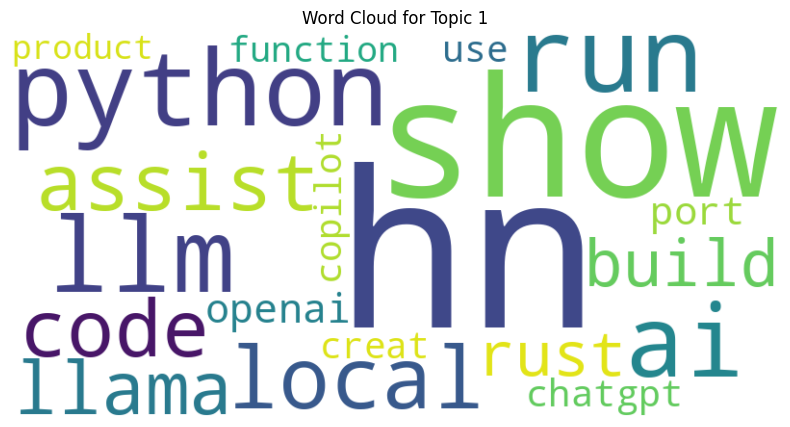

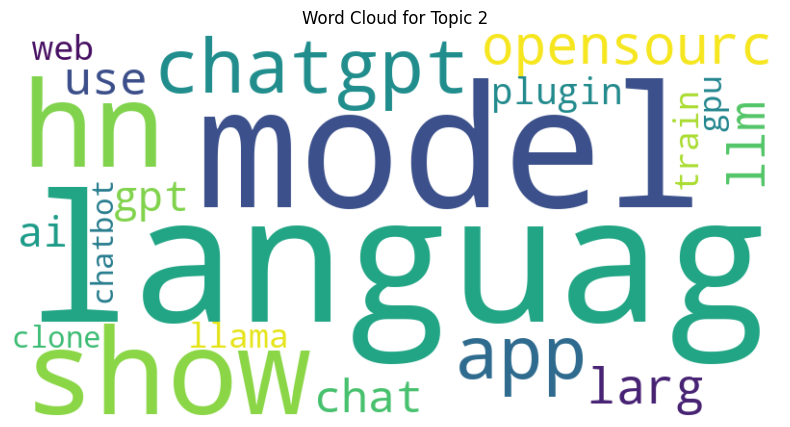

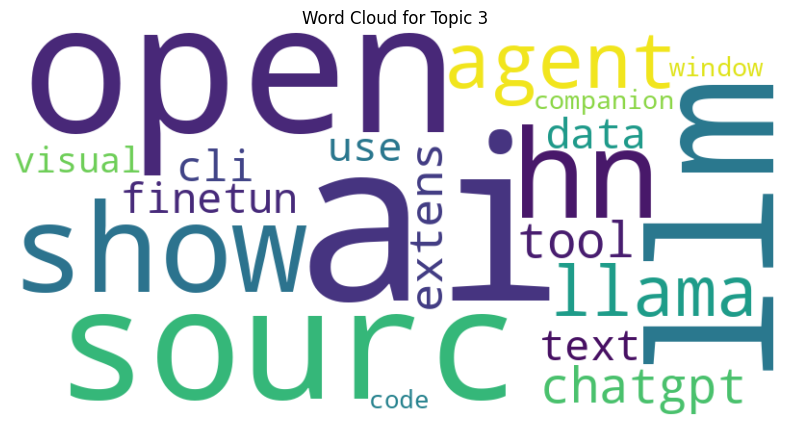

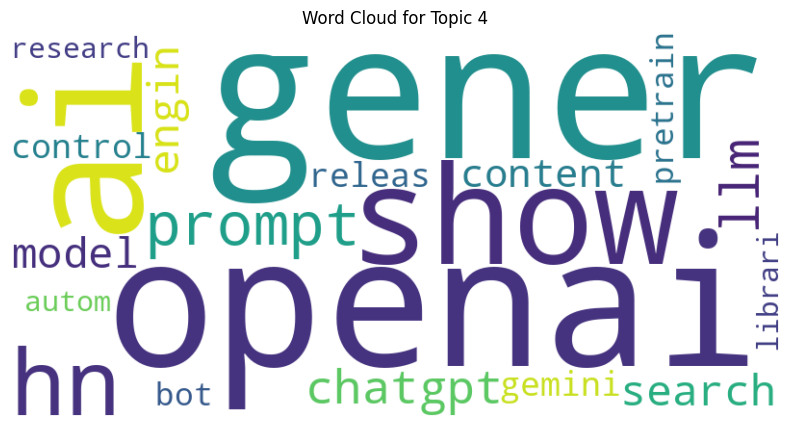

In [ ]:
# Assuming you have your lda_model and tfidf_vectorizer
create_wordcloud_for_topics(lda_model, tfidf_vectorizer.get_feature_names_out())